### Part 4 - Custom Architectures

### Load Initial DataLoaders

We want a 1-channel dataloader, `dls_1c` for training our custom architecture.

We want a 3-channels dataloader, dls_3c

In [12]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1
from module.mnist_helpers import img_pt_plot, train_history_dualplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
path = untar_data(URLs.MNIST_TINY)
df = build_df(path)

In [14]:
# remake a datablock with BW-style images

y_names = [
    'point_topleft_x', 
    'point_topleft_y',
    'point_center_x',
    'point_center_y'
    ]

db_1c = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(y_names[:2]),
                  )

dls_1c = db_1c.dataloaders(df)

dls_1c

x, y = dls_1c.one_batch()

x.shape

torch.Size([64, 1, 28, 28])

In [15]:
x_2 = x[:2]
x_2.shape

torch.Size([2, 1, 28, 28])

In [16]:
net3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=28),
            nn.Linear(in_features=28, out_features=2, bias=False),
            SigmoidRange(-1., 1),
            )


out_net3 = net3(x_2)
out_net3.shape

torch.Size([2, 2])

##### Build Learner and Fit
Pretty darn good

In [17]:
learn_net3 = Learner(dls_1c, net3, loss_func=MSELossFlat(), )

In [18]:
learn_net3.fit(1)

epoch,train_loss,valid_loss,time
0,0.111095,0.033443,00:01


In [132]:
preds = learn_net3.get_preds()

##### Fit some more, it gets even better

In [25]:
learn_net3.fit(10)

epoch,train_loss,valid_loss,time
0,0.012797,0.016049,00:01
1,0.012514,0.016004,00:01
2,0.012168,0.015967,00:01
3,0.011994,0.015726,00:01
4,0.011834,0.015890,00:01
5,0.011691,0.016298,00:01
6,0.011508,0.016076,00:01
7,0.011426,0.016289,00:01
8,0.011317,0.016236,00:01
9,0.011193,0.016385,00:01


In [20]:
def pva_plot(actuals, predcits, title=''):
    plt.scatter(actuals, predicts, alpha=0.4)
    y0, y1 = plt.ylim()
    x0, x1 = plt.xlim()
    full_area = [min(x0, y0), max(x1, y1)]
    plt.plot(full_area, full_area, linestyle='--')
    plt.xlabel('Actual'); plt.ylabel('Predicted');
    plt.title(f'{title} - Predicted vs Actual');

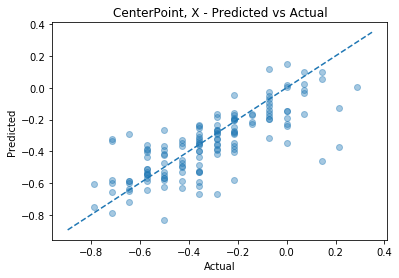

In [23]:
preds = learn_net3.get_preds()
actuals =  preds[1].view(-1,2)[:,0]
predicts = preds[0][:,0]

pva_plot(actuals, predicts, 'CenterPoint, X')

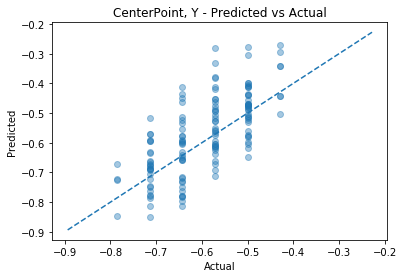

In [24]:
preds = learn_net3.get_preds()
actuals =  preds[1].view(-1,2)[:,1]
predicts = preds[0][:,1]

pva_plot(actuals, predicts, 'CenterPoint, Y')

##### Compare ResNet to Net3
All Hail Net3! a new SOTA on MNIST ImagePoint Tasks

In [165]:
preds_resnet = learn.get_preds()
preds_net3    = learn_net3.get_preds()

In [166]:
mse(preds_net3[0], preds_net3[1])

tensor(0.0017)

In [167]:
mse(preds_resnet[0], preds_resnet[1])

tensor(0.0068)

##### Visualize Residuals of each model

In [185]:
resids_net3 =   (preds_net3[0] - preds_net3[1].view(-1,2))
resids_resnet = (preds_resnet[0] - preds_resnet[1].view(-1,2))

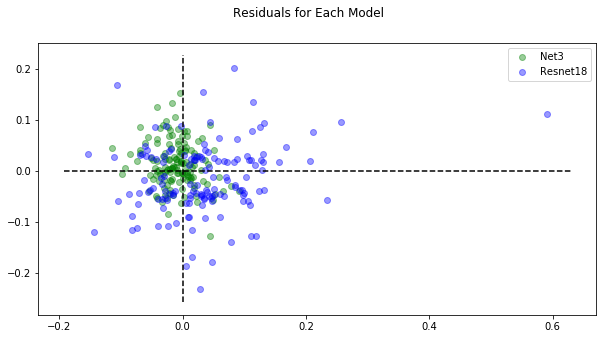

In [200]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.scatter(resids_net3[:,0], resids_net3[:,1], 
              c='green', alpha=0.4)
ax.scatter(resids_resnet[:,0], resids_resnet[:,1], 
              c='blue', alpha=0.4)
ax.legend(['Net3', 'Resnet18'])
ax.hlines(0, *ax.get_xlim(), linestyle='--')
ax.vlines(0, *ax.get_ylim(), linestyle='--')
fig.suptitle('Residuals for Each Model');